In [16]:
import math

# use of Haversin formula from:
# https://www.kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python

def geodist1(lat1,lon1,lat2,lon2):
    R = 6373.0  # radius of the Earth (assume Earth spherical)

    la1 = math.radians(lat1)
    lo1 = math.radians(lon1)
    la2 = math.radians(lat2)
    lo2 = math.radians(lon2)

    dlon = lo2 - lo1
    dlat = la2 - la1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(la1) * math.cos(la2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c * 1000
        
#     return round(d,1)  # distance in metres
    return d

In [17]:
from geopy.distance import distance

# use of geopy based on:
# https://geopy.readthedocs.io/en/stable/#module-geopy.distance

def geodist2(lat1,lon1,lat2,lon2):
    coords_1 = (lat1,lon1)
    coords_2 = (lat2,lon2)
    d = distance(coords_1, coords_2).m
    
#     return round(d,1)  # distance in metres
    return d



In [30]:
lat1 = 41.49038
lon1 = -71.312796
lat2 = 41.499498
lon2 = -81.695791

print("geodist1 using haversine formula : ", geodist1(lat1,lon1,lat2,lon2),"m")
print("geodist1 using geopy library : ", geodist2(lat1,lon1,lat2,lon2),"m")

geodist1 using haversine formula :  864515.8 m
geodist1 using geopy library :  866486.7 m


In [1]:
## develop some geo filters using geopandas below

import numpy as np
from sodapy import Socrata
import geopandas
import pandas as pd
from shapely.geometry import Polygon, Point

# https://geopandas.org/docs/reference/geoseries.html

In [2]:
# create base list of parking bays with marker ids from "On-street Parking Bays" dataset (crvt-b4kt)
_gdf = geopandas.read_file("datasets/006_crvt-b4kt_dl_at__20210808_manual.geojson")
_gdf['last_edit'] = pd.to_datetime(_gdf['last_edit'])
gdf_wgs84 = _gdf.sort_values(by='last_edit', ascending=False)

gdf_wgs84['centroid'] = gdf_wgs84.centroid
gdf_wgs84['lati'] = gdf_wgs84['centroid'].y  # coordinates from geojson polygon's centroids
gdf_wgs84['long'] = gdf_wgs84['centroid'].x

gdf_7842 = gdf_wgs84.to_crs("EPSG:7842")  # convert to Australian CRS projection for metric calculations
gdf_7842['area_m2'] = gdf_7842.area
# to WGS84, use "EPSG:4326"

gdf2 = gdf_wgs84.drop(columns=['bay_id','meter_id','last_edit'])
gdf3 = gdf_7842[['area_m2']]
gdf_ = pd.concat([gdf2, gdf3], axis='columns')
gdf_ = gdf_.fillna(value=np.nan)
gdf_ = gdf_[gdf_['marker_id'].notna()]  # keep only rows with marker id
gdf_baselist = gdf_.drop_duplicates('marker_id')

gdf_bl_poly = gdf_baselist.drop(columns='centroid')
gdf_bl_cen = gdf_baselist.drop(columns='geometry').set_geometry('centroid')

# problem saving to geojson with both 'geometry' and 'centroid' (both geometry)
# so save per below
gdf_baselist.to_csv('datasets/onStreetParkingBays_baselist.csv', index=False)
gdf_bl_poly.to_file('datasets/onStreetParkingBays_baselist_bayPolygon.geojson', driver='GeoJSON')
gdf_bl_cen.to_file('datasets/onStreetParkingBays_baselist_bayCentroid.geojson', driver='GeoJSON')

ipykernel_launcher:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [3]:
# set polygon to filter within
lat1, lon1 = -37.81192120679105, 144.95628148775384
lat2, lon2 = -37.81036832849929, 144.9616049327078
lat3, lon3 = -37.806134720609734, 144.95972125218563
lat4, lon4 = -37.805700253666316, 144.95569649380283
lat5, lon5 = -37.80921289191341, 144.95508810009383

polygon = Polygon([(lon1, lat1), (lon2, lat2), (lon3, lat3), (lon4, lat4), (lon5, lat5)])

# clip base list with polygon .. and save clipped list to geojson
# need to have 'pip install rtree' for below clip to work
gdf_pb_polygon_clipped = geopandas.clip(gdf_bl_cen, polygon)
gdf_pb_polygon_clipped.to_file('datasets/pb_polygon_clipped.geojson', driver='GeoJSON')  # open geojson from map viewer


In [4]:
# define function that is adapted from:
# https://gis.stackexchange.com/questions/367496/plot-a-circle-with-a-given-radius-around-points-on-map-using-python
# https://gis.stackexchange.com/questions/121256/creating-a-circle-with-radius-in-metres
# don't understand below part
#    local_azimuthal_projection = "+proj=aeqd +R=6371000
# so I may be off
# but results seem not too far off .. so find out what above means and adjust
# the 2 CRS I am switching between are "EPSG:4326" (WGS84 and lat lon) <--> "EPSG:7842" (Aust and metric)

from functools import partial
import pyproj
from shapely.ops import transform

def cirp(lat, lon, radius):  # radius in m
    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(lat, lon)
    
    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
        pyproj.Proj(local_azimuthal_projection))
    
    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"))

    pin = Point(lon, lat)
    point_transformed = transform(wgs84_to_aeqd, pin)
    buffer = point_transformed.buffer(radius)
    
    circle_poly = transform(aeqd_to_wgs84, buffer)
    return circle_poly

In [5]:
# set pin and radius in metres# set pin and radius in metres
latp, lonp = -37.81192120679105, 144.95628148775384
radius_metres = 200  #  too small radius will not filter any parking bays

circle = cirp(latp, lonp, radius_metres)
gdf_pb_circle_clipped = geopandas.clip(gdf_bl_cen, circle)
gdf_pb_circle_clipped.to_file('datasets/pb_circle_clipped.geojson', driver='GeoJSON') # will error if writing empty gdf
gdf_pb_circle_clipped.shape


(99, 7)

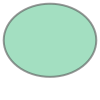

In [1]:
from d2i_tools import *

a = cirp(-37.81192120679105, 144.95628148775384, 100)
a

In [2]:
type(a)

shapely.geometry.polygon.Polygon

In [13]:
# adapting Miriam's geo filter

from geopy.distance import geodesic
import numpy as np

def geofilter(data,pin,n):
    lst_marker_ids = []
    j=0
    for i in np.arange(0,data.shape[0]):
        d = geodesic(pin, (data.lati[i],data.long[i])).meters
        if d<=n:
            lst_marker_ids.append(data.marker_id[i])
            j=j+1
        else:
            continue
    return lst_marker_ids

In [2]:
import geopandas

pin = (-37.812389676018476, 144.95817254056357)  # centre of Little Lonsdale St (btw William St & Queen St)
n = 100  # radius in metres
gdf = geopandas.read_file("datasets/onStreetParkingBays_baselist_bayCentroid.geojson")  # base list of 5895 marker ids


In [20]:
filtered = geofilter(gdf,pin,200)

In [21]:
from d2i_tools import genPSdata, getCurrentPSstatus, timeIntStats, filterById, geoPolyClip

df_filtered = filterById(filtered, "marker_id", gdf)
print(f"shape of filtered data is {df_filtered.shape}")

df_filtered.head(3)

shape of filtered data is (197, 7)


,rd_seg_id,marker_id,rd_seg_dsc,lati,long,area_m2,geometry
38,20046,3507S,Little Lonsdale Street between William Street ...,-37.812944,144.956245,9.108119,POINT (144.95624 -37.81294)
203,20177,1268E,Queen Street between Little Lonsdale Street an...,-37.811624,144.959284,7.888399,POINT (144.95928 -37.81162)
218,20177,1272E,Queen Street between Little Lonsdale Street an...,-37.811577,144.959263,6.779000,POINT (144.95926 -37.81158)


In [22]:
df_filtered.to_file("datasets/circledData.geojson", driver="GeoJSON")

In [11]:
gdf.lati[0]

-37.80644722956869

In [9]:
gdf.head(3)

,rd_seg_id,marker_id,rd_seg_dsc,lati,long,area_m2,geometry
0,23247,C5010,Queen Street between Therry Street and Victori...,-37.806447,144.958202,9.388646,POINT (144.95820 -37.80645)
1,23247,4999W,Queen Street between Therry Street and Victori...,-37.806586,144.958043,8.148094,POINT (144.95804 -37.80659)
2,20173,1114E,Queen Street between Little Collins Street and...,-37.815324,144.960975,6.970730,POINT (144.96098 -37.81532)


In [10]:
gdf.marker_id[1]

'4999W'

In [4]:
from geopy.distance import geodesic

pin_t = (-37.81185179401935, 144.95978287876648)

geodesic(pin,pin_t).meters



153.85537235818168

In [3]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5895 entries, 0 to 5894
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   rd_seg_id   5713 non-null   object  
 1   marker_id   5895 non-null   object  
 2   rd_seg_dsc  5713 non-null   object  
 3   lati        5895 non-null   float64 
 4   long        5895 non-null   float64 
 5   area_m2     5895 non-null   float64 
 6   geometry    5895 non-null   geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 322.5+ KB
